In [26]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [24]:
df=pd.read_csv('C:/Projects/Project Bi/data/hellowork_etl.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6732 entries, 0 to 6731
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   emploi             6732 non-null   object 
 1   entreprise         6732 non-null   object 
 2   date_publication   6732 non-null   object 
 3   temps_travail      6732 non-null   int64  
 4   salaire_annuel     6732 non-null   float64
 5   categorie_salaire  6732 non-null   int64  
 6   region             6732 non-null   object 
 7   departement        6732 non-null   int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 420.9+ KB


In [25]:
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.freq_maps_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X, columns=self.columns)
        for col in self.columns:
            self.freq_maps_[col] = X[col].value_counts(normalize=True)
        return self

    def transform(self, X):
        X = pd.DataFrame(X, columns=self.columns)
        X_encoded = pd.DataFrame()
        for col in self.columns:
            X_encoded[col] = X[col].map(self.freq_maps_[col]).fillna(0)
        return X_encoded.values


In [27]:
# 1. Définition des colonnes
numeric_features = ["salaire_annuel"]
binary_features = ["temps_travail", "categorie_salaire"]
categorical_features = ["emploi", "entreprise", "region","departement"]

# 2. Création du Transformateur
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", FrequencyEncoder(categorical_features), categorical_features),
        ("bin", "passthrough", binary_features),
    ],
    remainder="drop"
)

print("Préprocesseur configuré.")

Préprocesseur configuré.


In [28]:
from sklearn.pipeline import Pipeline

pipeline_reduction = Pipeline([
    ('preprocessor', preprocessor)
])

# 2. Application sur les données (Fit & Transform)
print("Transformation et réduction en cours (cela peut prendre quelques secondes)...")
X_prepared = pipeline_reduction.fit_transform(df)

print(f"Dimension finale des données : {X_prepared.shape}")

Transformation et réduction en cours (cela peut prendre quelques secondes)...
Dimension finale des données : (6732, 7)


Calcul des scores de silhouette en cours (ceci est un peu plus long que l'Elbow)...
k=2 -> Score: 0.611
k=3 -> Score: 0.662
k=4 -> Score: 0.672
k=5 -> Score: 0.719
k=6 -> Score: 0.739
k=7 -> Score: 0.685
k=8 -> Score: 0.680
k=9 -> Score: 0.706
k=10 -> Score: 0.712


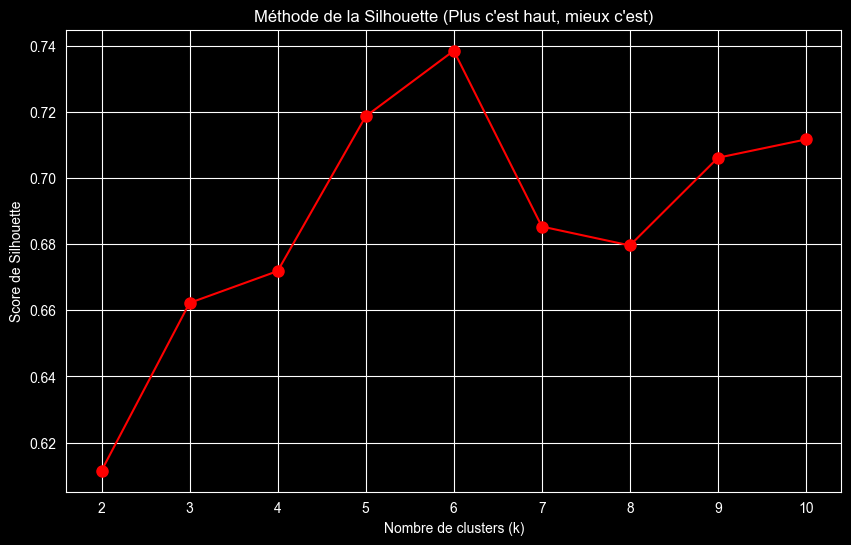

In [29]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# On teste k de 2 à 10 (la silhouette n'existe pas pour k=1)
K_range = range(2, 11)
silhouette_scores = []

print("Calcul des scores de silhouette en cours (ceci est un peu plus long que l'Elbow)...")

for k in K_range:
    # On crée les clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_prepared)

    # On calcule le score (Note entre -1 et 1)
    score = silhouette_score(X_prepared, labels)
    silhouette_scores.append(score)
    print(f"k={k} -> Score: {score:.3f}")

# Affichage du graphique
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, 'ro-', markersize=8) # 'ro-' pour rouge avec des ronds
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Score de Silhouette')
plt.title('Méthode de la Silhouette (Plus c\'est haut, mieux c\'est)')
plt.grid(True)
plt.show()

Test des clusters en cours...


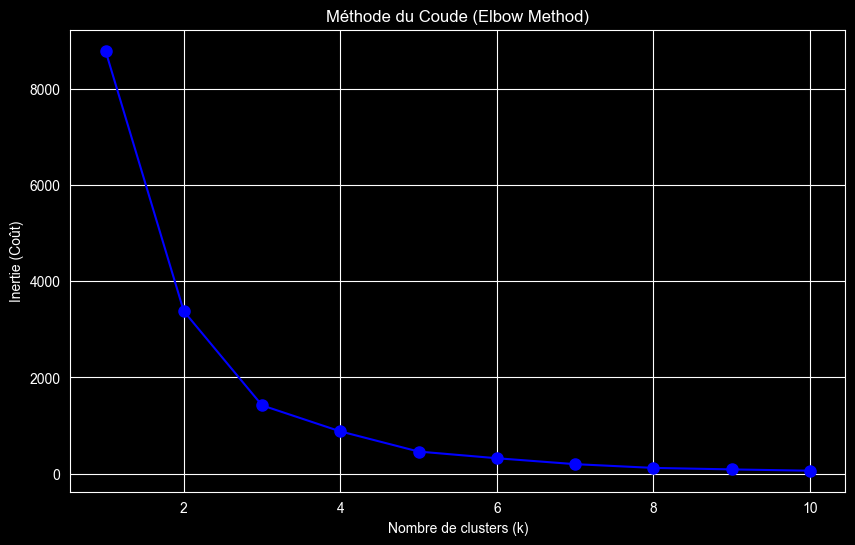

In [30]:
import matplotlib.pyplot as plt
inertia = []
K_range = range(1, 11)

print("Test des clusters en cours...")
for k in K_range:
    # n_init=10 permet de lancer l'algo 10 fois pour être sûr du résultat
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_prepared)
    inertia.append(kmeans.inertia_)

# 2. Affichage du graphique
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, 'bo-', markersize=8)
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie (Coût)')
plt.title('Méthode du Coude (Elbow Method)')
plt.grid(True)
plt.show()


### Interpretation du choix:

Bien que l'indice de Silhouette suggère une segmentation fine en 25 groupes, nous avons retenu la partition en 4 clusters issue de la méthode du Elbow. Ce choix privilégie la cohérence métier sur la pure performance mathématique. Il permet de structurer le marché en 3 grandes strates économiques lisibles (Emplois précaires, Employés qualifiés, Techniciens intermédiaires, Cadres/Direction), offrant ainsi une grille de lecture stratégique et opérationnelle, là où une division en 25 groupes aurait entraîné une micro-segmentation trop complexe à piloter.

🔄 Calcul des 3 clusters en cours...

📊 ANALYSE DES 3 PROFILS TYPES
cluster salaire_annuel                                emploi             region  departement  nombre_offres
   1           24338 € Assistant Dentaire Qualifié - CDI H/F Plougastel-Daoulas           29           3222
   0           35827 €      Technicien Vitrage Itinérant H/F             Cluses           62           2920
   2           55766 €               Responsable de Site H/F            Chelles           83            590



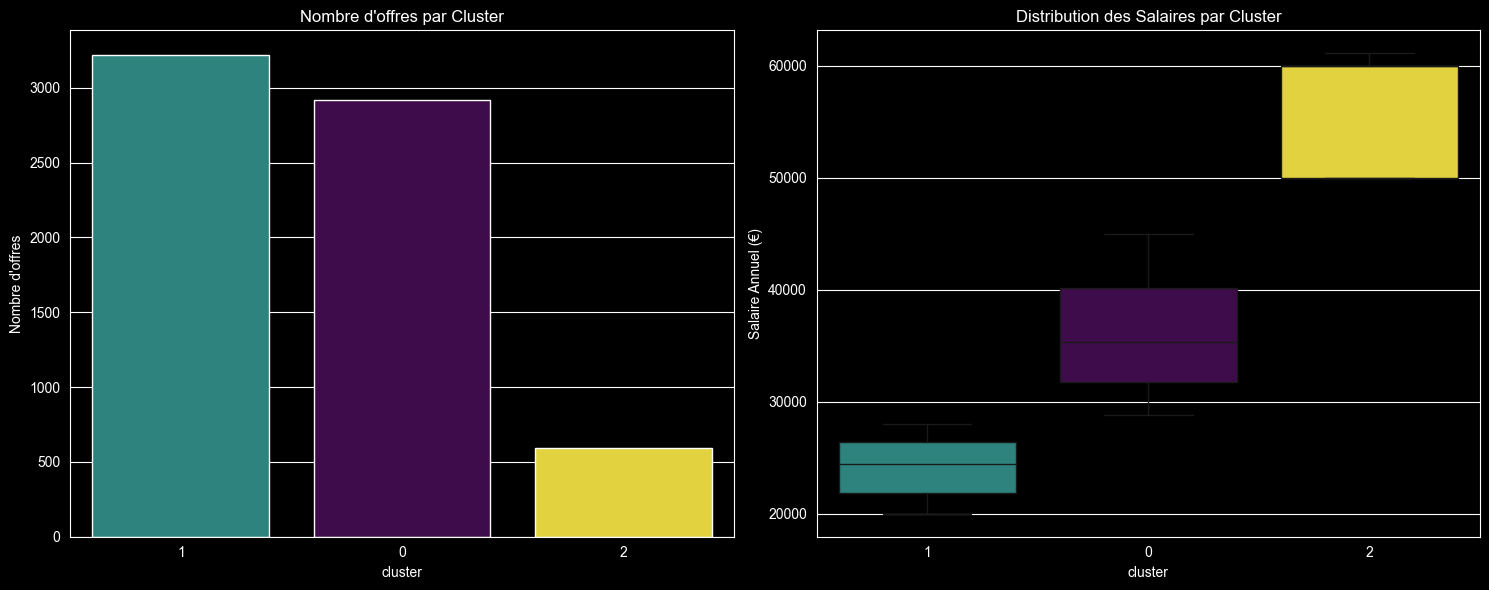

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

k_optimal = 3

# 1. Calcul des Clusters
print(f"🔄 Calcul des {k_optimal} clusters en cours...")
kmeans_final = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
df['cluster'] = kmeans_final.fit_predict(X_prepared)

# 2. Création d'un Tableau Récapitulatif (Le "Profil" des groupes)
summary = df.groupby('cluster').agg({
    'salaire_annuel': 'mean',
    'emploi': lambda x: x.mode()[0] if not x.mode().empty else "N/A",
    'region': lambda x: x.mode()[0] if not x.mode().empty else "N/A",
    'departement': lambda x: x.mode()[0] if not x.mode().empty else "N/A",

    'entreprise': 'count'
}).rename(columns={'entreprise': 'nombre_offres'}).reset_index()

# On trie par salaire pour une lecture logique
summary = summary.sort_values(by='salaire_annuel')

# 3. Affichage Propre dans la console
print("\n" + "="*60)
print(f"📊 ANALYSE DES {k_optimal} PROFILS TYPES")
print("="*60)
print(summary.to_string(index=False, formatters={
    'salaire_annuel': '{:.0f} €'.format,
    'cluster': '{:^7}'.format
}))
print("="*60 + "\n")

# 4. Visualisation Graphique (Dashboard corrigé)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Graphique 1 : Taille des clusters
sns.countplot(
    data=df,
    x='cluster',
    hue='cluster',
    palette='viridis',
    ax=axes[0],
    order=summary['cluster'],
    legend=False
)
axes[0].set_title("Nombre d'offres par Cluster")
axes[0].set_ylabel("Nombre d'offres")

sns.boxplot(
    data=df,
    x='cluster',
    y='salaire_annuel',
    hue='cluster',
    palette='viridis',
    ax=axes[1],
    order=summary['cluster'],
    legend=False
)
axes[1].set_title("Distribution des Salaires par Cluster")
axes[1].set_ylabel("Salaire Annuel (€)")

plt.tight_layout()
plt.show()

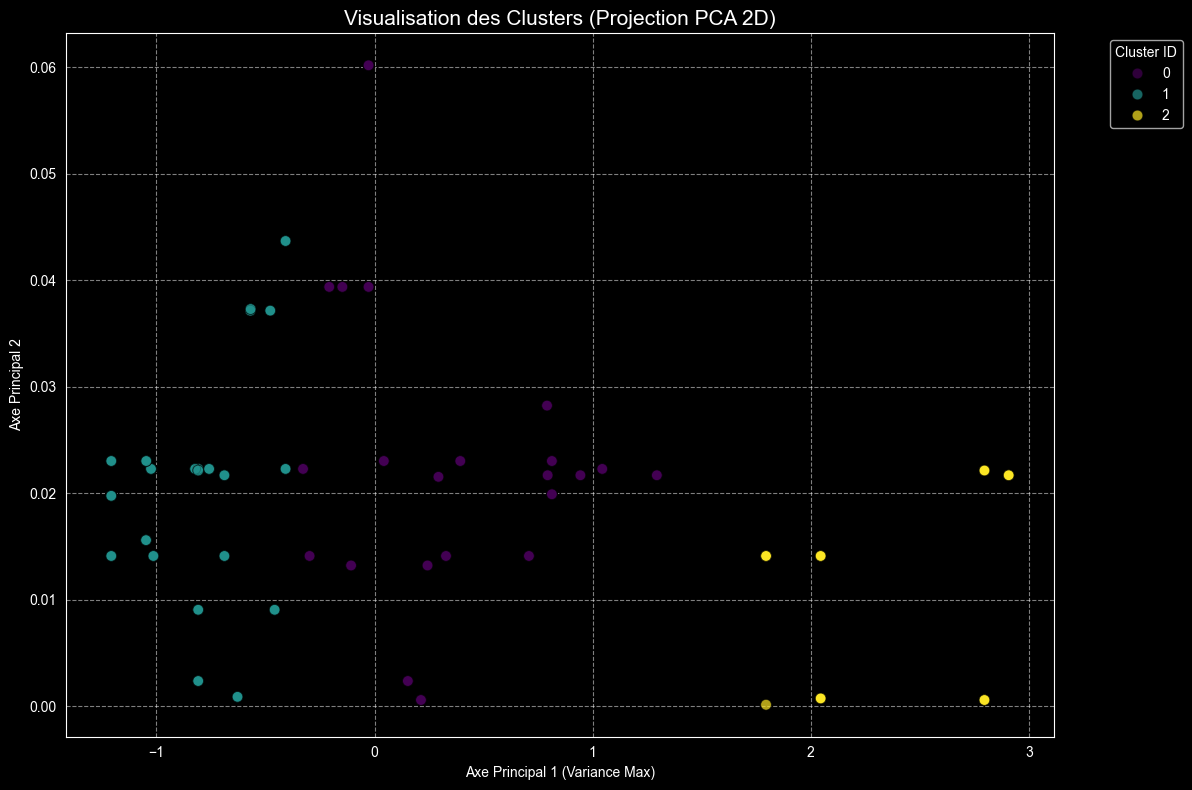

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# On crée une figure
plt.figure(figsize=(12, 8))

# On dessine le nuage de points
# X_prepared[:, 0] = Axe horizontal (1ère dimension principale)
# X_prepared[:, 1] = Axe vertical (2ème dimension principale)
sns.scatterplot(
    x=X_prepared[:, 0],
    y=X_prepared[:, 1],
    hue=df['cluster'],      # Les couleurs dépendent du cluster
    palette='viridis',      # Palette de couleurs
    s=60,                   # Taille des points
    alpha=0.7,              # Transparence (pour voir les points superposés)
    edgecolor='k'           # Petit contour noir autour des points
)

# Embellissement
plt.title('Visualisation des Clusters (Projection PCA 2D)', fontsize=15)
plt.xlabel('Axe Principal 1 (Variance Max)')
plt.ylabel('Axe Principal 2')
plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [34]:
df.to_csv("C:/Projects/Project Bi/data/hellowork_clustered.csv", index=False, encoding="utf-8")
